# Data Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

## pretraining data

In [3]:
from typing import Literal

class TwoArmLinkDataset(Dataset):
	def __init__(self, n_tasks=1500, n_episode=150, n_timesteps=10, control: Literal['rand','pd'] = 'rand') -> None:
		super().__init__()
		self.x_0 = []
		self.u = []
		self.x = []
		self.z = []
		l_of_tasks = np.random.normal(loc=1, scale=0.3, size=(n_tasks,2))
		for i in tqdm(range(n_tasks)):
			l = l_of_tasks[i]
			for j in range(n_episode):
				x_0, u, x, z = TwoArmLinkDataset.generate_episode(l, n_timesteps, control=control)
				self.x_0.append(x_0)
				self.u.append(u)
				self.x.append(x)
				self.z.append(z)

	def __getitem__(self, index):
		x_0 = self.x_0[index]
		u = self.u[index]
		x = self.x[index]
		z = self.z[index]
		sample = {
			"init_pos": torch.tensor(x_0),
			"control": torch.tensor(u),
			"true_pos": torch.tensor(x),
			"noisy_pos": torch.tensor(z),
		}
		return sample

	def __len__(self):
		return len(self.x_0)

	@staticmethod
	def generate_episode(l, n_timesteps, control: Literal['rand','pd']):
		def x_of_q(q, l):
			'''
			q: array (2,) containing the two angles
			l: array (2,) containing the two limb lengths 
			'''
			x = l[0] * np.cos(q[0]) + l[1] * np.cos(q[0] + q[1])
			y = l[0] * np.sin(q[0]) + l[1] * np.sin(q[0] + q[1])
			return np.array([x, y])
		
		q_0 = np.random.uniform(low= -np.pi, high= np.pi, size=2)
		x_0 = x_of_q(q=q_0,l=l)
		u = np.random.randn(2, n_timesteps)
		q = u.cumsum(axis=1) + q_0.reshape(-1,1)
		x = x_of_q(q, l=l)
		z = x + np.random.normal(0, scale=0.001, size=(2, n_timesteps))
		return x_0, u, x, z

In [9]:
dataset = TwoArmLinkDataset()

100%|██████████| 1500/1500 [00:16<00:00, 91.14it/s] 


In [40]:
dataset[0]

{'init_pos': tensor([-1.0859,  0.6642], dtype=torch.float64),
 'control': tensor([[ 1.5262,  0.0481,  0.6559,  0.4097,  1.0826, -0.7199, -2.1535, -0.5783,
           1.4463, -0.0688],
         [ 0.7410, -0.7139,  2.1297, -1.2783,  1.1284, -0.3392,  0.0805,  1.1137,
          -1.1610, -0.1723]], dtype=torch.float64),
 'true_pos': tensor([[-0.4507, -0.6537,  0.7808,  0.9930,  0.8540,  1.2193, -0.7531, -0.6420,
           0.2158,  0.0680],
         [-1.2799, -1.0991, -0.7239, -0.9206,  0.7256, -0.1442, -0.9406, -0.3917,
          -1.1993, -1.2612]], dtype=torch.float64),
 'noisy_pos': tensor([[-0.4510, -0.6536,  0.7805,  0.9920,  0.8530,  1.2192, -0.7526, -0.6425,
           0.2168,  0.0671],
         [-1.2796, -1.0969, -0.7241, -0.9202,  0.7255, -0.1448, -0.9395, -0.3910,
          -1.2004, -1.2626]], dtype=torch.float64)}

In [6]:
x = dataset[0]['true_pos']
z = dataset[0]['noisy_pos']

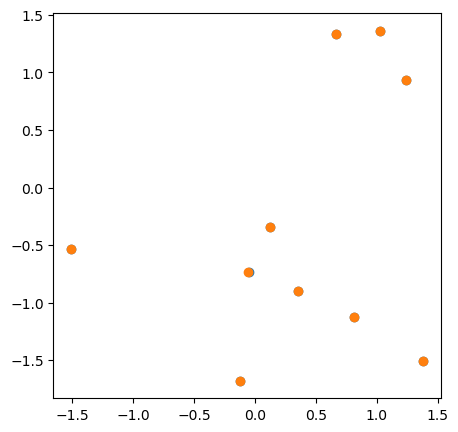

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(*x.numpy())
plt.scatter(*z.numpy())

In [72]:
torch.save(dataset, 'two_arm_link_dataset')

## test data

In [2]:
from math import pi,sqrt, cos, sin
from typing import Literal

class TwoArmLinkTestDataset(Dataset):
	def __init__(self, n_tasks=100, n_episode=1, n_timesteps=200) -> None:
		super().__init__()
		self.l = []
		self.q_0 = []
		self.x_g = []
		self.x = []
		self.z = []
		l_of_tasks = np.random.normal(loc=1, scale=0.3, size=(n_tasks,2))
		for i in tqdm(range(n_tasks)):
			l = l_of_tasks[i]
			self.l.append(l)
			for j in range(n_episode):
				q_0, x_g, x, z = TwoArmLinkTestDataset.generate_episode(l, n_timesteps)
				self.q_0.append(q_0)
				self.x_g.append(x_g)
				self.x.append(x)
				self.z.append(z)

	def __getitem__(self, index):
		l = self.l[index]
		q_0 = self.q_0[index]
		x_g = self.x_g[index]
		x = self.x[index]
		z = self.z[index]
		sample = {
			"limb_len": torch.tensor(l),
			"init_pos": torch.tensor(q_0),
			"target_pos": torch.tensor(x_g),
			"true_pos": torch.tensor(x),
			"noisy_pos": torch.tensor(z),
		}
		return sample

	def __len__(self):
		return len(self.x_0)

	@staticmethod
	def generate_episode(l, n_timesteps):
		def fk(q, l):
			'''
			forward_kinematics
			q: array (2,) containing the two angles
			l: array (2,) containing the two limb lengths 
			'''
			x = l[0] * np.cos(q[0]) + l[1] * np.cos(q[0] + q[1])
			y = l[0] * np.sin(q[0]) + l[1] * np.sin(q[0] + q[1])
			return np.array([x, y])
		def pd(q, x, xg, dq, k=[1,1e-2], l=l):
			'''
			pd control
			q : angle at time t array(2,)
			x : position at time t array(2,)
			xg : target position array(2,)
			dq : control at t-1 array(2,)
			k : hyperparameter array(2,)
			l : link length array(2,)
			'''
			a = l[0]*np.sin(q[0])
			b = l[0]*np.cos(q[0])
			c = l[1] * np.sin(q[0] + q[1])
			d = l[1] * np.cos(q[0] + q[1])
			# jac = np.array([[ -l[0] * np.sin(q[0]) - l[1] * np.sin(q[0] + q[1]), -l[1] * np.sin(q[0] + q[1])],
			# 								[ l[0] * np.cos(q[0]) + l[1] * np.cos(q[0] + q[1]), l[1] * np.cos(q[0] + q[1])]])
			jac = np.array([[ -a-c, -c],
											[ b+d, d]])
			u = - k[0] * np.matmul(jac , (x - xg)) - k[1] * dq
			return u
		def randpt_in_circle(radius):
			r = radius * sqrt(random.random())
			theta = random.random() * 2 * pi
			x = r * cos(theta)
			y = r * sin(theta)
			return np.array([x,y])
		q_0 = np.random.uniform(low= -np.pi, high= np.pi, size=2)
		# print(q_0)
		x_0 = fk(q=q_0,l=l)
		x_g = randpt_in_circle(radius=0.1) + x_0
		q_t = q_0.copy()
		q = []
		x = []
		u_t = 0
		for i in range(n_timesteps):
			q.append(q_t)
			x_t = fk(q=q_t,l=l)
			x.append(x_t)
			u_t = pd(q_t, x=x_t, xg=x_g, dq=u_t)
			q_t += u_t

		x = np.asarray(x)
		z = x + np.random.normal(0, scale=0.001, size=x.shape)
		return q_0, x_g, x, z

In [3]:
testset = TwoArmLinkTestDataset()

100%|██████████| 100/100 [00:00<00:00, 118.10it/s]


In [4]:
torch.save(testset, 'two-links-arm-test')

In [26]:
singular = []
for i in range(100):
	t = testset[i]
	init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	if not np.allclose(true_pos[-1], target_pos, rtol=1):
		singular.append(i)

print(len(singular)/100)

0.19


In [27]:
singular

[2, 3, 6, 28, 33, 34, 37, 39, 40, 60, 62, 63, 65, 67, 75, 81, 86, 92, 94]

In [31]:
def plot_trace(t):
	init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	plt.figure()
	plt.scatter(*init_pos, label='init_pos')
	plt.scatter(*target_pos, label='target_pos')
	plt.plot(true_pos[50:,0], true_pos[50:,1], label='true_pos')
	plt.legend()